# Computer Vision - Object Detection and Classification example

###### Fashion dataset (Kaggle)  https://www.kaggle.com/datafiniti/womens-shoes-prices

### 0 - Setup

###### Import pckgs

In [2]:
import warnings
warnings.filterwarnings("ignore")
from cv_utils import *

###### Import data

In [3]:
# Reading the csv with price and image url
import csv

with open('data/data.csv', 'r') as file:
    table = csv.reader(file, delimiter=',')
    
    ## skip headers
    next(table, None)
    
    ## some items are the same, I'll keep the unique values (653 rows)
    lst_id, data = [], []
    for row in table:
        if row[0] not in lst_id:
            lst_id.append(row[0])
            price = float(row[16])
            price_class = "0_50" if (price <= 50) else ("over100" if (price > 100) else "50_100")
            data.append({"url":row[10], "price":price, "price_class":price_class})
        else:
            next
    
    ## insert a custom id
    for i,dic in enumerate(data):
        dic["id"]=i
        
print("len:", len(data))
data[0]

len: 653


{'url': 'https://i5.walmartimages.com/asr/861ca6cf-fa55-4a48-904d-b764d7c00f0c_1.1a2bb39923e1486d05bdafe37ad832e3.jpeg?odnHeight=450&odnWidth=450&odnBg=FFFFFF,https://i5.walmartimages.com/asr/efe9ba1e-daed-4534-9e2e-11804bbb30f1_1.62e3e7f0268f641323a245d5caebdd6d.jpeg?odnHeight=450&odnWidth=450&odnBg=FFFFFF,https://i5.walmartimages.com/asr/0c717815-228e-4c9b-a8fc-d033576461c9_1.f08402e0a5165746e133ddeb589c73e0.jpeg?odnHeight=450&odnWidth=450&odnBg=FFFFFF,https://i5.walmartimages.com/asr/f46703c8-2cdb-4bf2-a3ea-819f24aab134_1.df725b76ca0112d64bdf566ad97760a9.jpeg?odnHeight=450&odnWidth=450&odnBg=FFFFFF,https://i5.walmartimages.com/asr/f652f354-a1fb-47ac-b507-7f97eb216b14_1.39e78b87e2328421803115869ee8b950.jpeg?odnHeight=450&odnWidth=450&odnBg=FFFFFF,http://ak1.ostkcdn.com/images/products/84/146/P16141204.jpg,http://s1.shoes.com/images/br021/womens-naturalizer-danya-soft-silver-crosshatch-shiny-377672_366_tp.jpg,http://s3.shoes.com/images/br021/womens-naturalizer-danya-soft-silver-crossh

In [8]:
# Create the file system structure
import os

lst_folders = ["raw_images", "pretrained_models",
               "training_yolo/train/images", "training_yolo/train/annotations",
               "training_yolo/validation/images", "training_yolo/validation/annotations",
               "training_cnn/train/0_50", "training_cnn/train/50_100", "training_cnn/train/over100",
               "training_cnn/validation/0_50", "training_cnn/validation/50_100", "training_cnn/validation/over100"
               ]
for folder in lst_folders:
    if not os.path.exists("fs/"+folder):
        os.makedirs("fs/"+folder)

## print folder structure
for root, dirs, files in os.walk("fs"):
    path = root.split(os.sep)
    print((len(path) - 1) * ' -', os.path.basename(root))
    for file in files:
        print(len(path) * '  ', file)

 fs
 - pretrained_models
     detection_config.json
     yolo_base.h5
     yolo_shoes_nopreprocess.h5
 - raw_images
 - training_cnn
 - - train
 - - - 0_50
 - - - 50_100
 - - - over100
 - - validation
 - - - 0_50
 - - - 50_100
 - - - over100
 - training_yolo
 - - train
 - - - annotations
 - - - images
 - - validation
 - - - annotations
 - - - images


In [9]:
# Scraping the imgaes from the web and downloading on file system
import requests

for dic in data:
    try:
        res = requests.get(dic["url"])
        if res.status_code == 200:
            file_name = str(dic["id"])+'.jpg'
            file = open("fs/raw_images/"+file_name,'wb')
            file.write(res.content)
            file.close()
            
    except Exception as e:
        print("failed on:", dic["id"], "| res:", res.status_code, " | error:", e)
        next

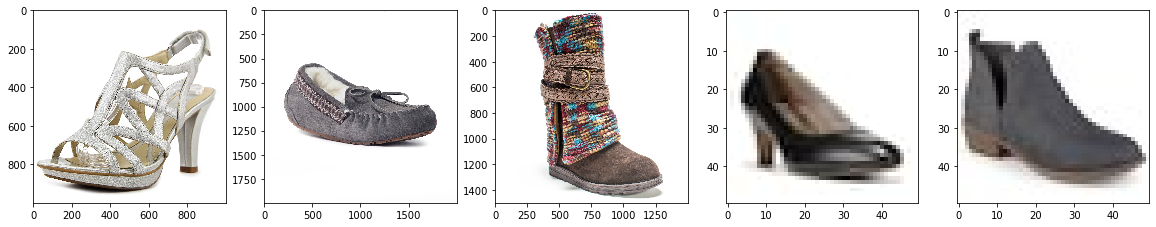

shape: (1000, 1000, 3)


In [4]:
# Load all images
lst_imgs = load_imgs(dirpath="fs/raw_images/", plot=True, ext=['.png','.jpg','.jpeg','.JPG'])
print("shape:", lst_imgs[0].shape)

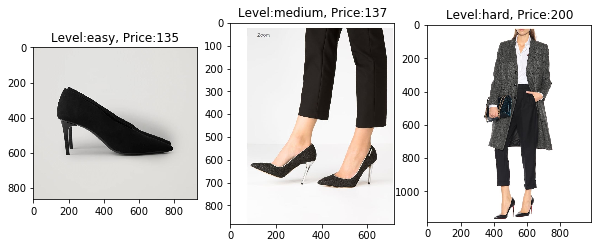

In [5]:
# Load Validation images
lst_new_imgs = load_imgs(dirpath="data/")
plot_imgs(lst_new_imgs, lst_titles=["Level:easy, Price:135", "Level:medium, Price:137", "Level:hard, Price:200"], figsize=(10,5))

### 1 - Image Analysis

###### Target Variable

len: 653
mean: 59.81194486983154


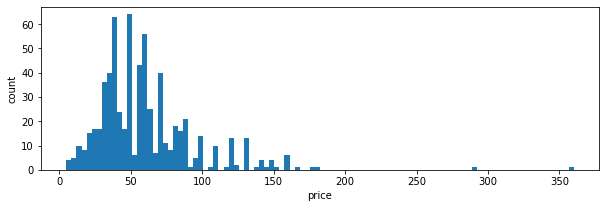

In [12]:
y = [dic["price"] for dic in data]

print("len:", len(y))
print("mean:", np.mean(y))

fig, ax = plt.subplots(figsize=(10,3))
ax.hist(y, bins=100)
ax.set(xlabel='price', ylabel="count")
plt.show()

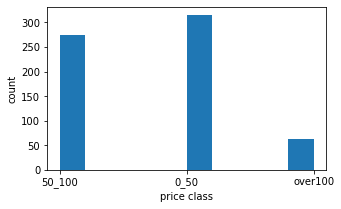

In [13]:
y = [dic["price_class"] for dic in data]

fig, ax = plt.subplots(figsize=(5,3))
ax.hist(y)
ax.set(xlabel='price class', ylabel="count")
plt.show()

###### Size

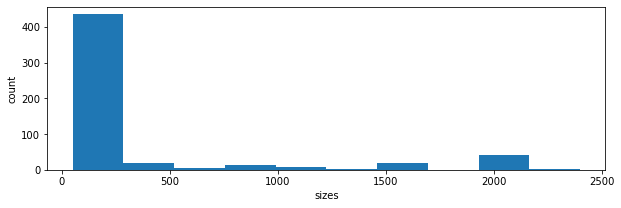

In [14]:
sizes = [i.shape[0] for i in lst_imgs]

fig, ax = plt.subplots(figsize=(10,3))
ax.hist(sizes, bins=10)
ax.set(xlabel='sizes', ylabel="count")
plt.show()

###### Colors

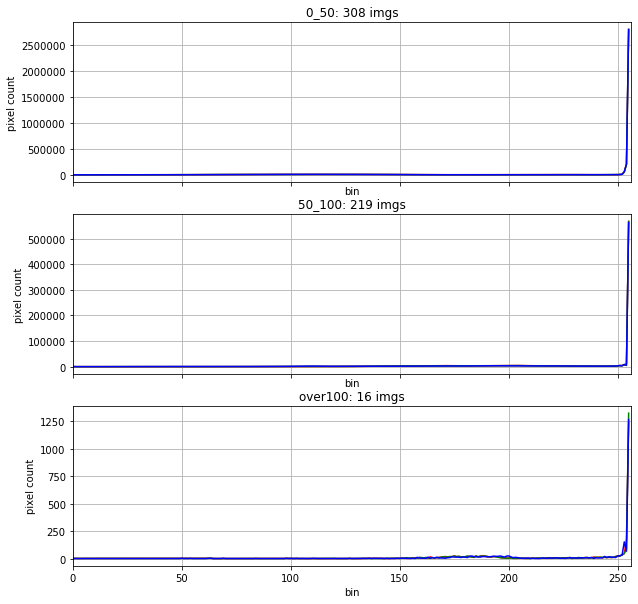

In [15]:
utils_color_distributions(lst_imgs, y, figsize=(10,10))

### 2 - Preprocessing for Classification

###### Partitioning

In [17]:
# Copying images into train / test folders.
import shutil

split = int(len(data)*0.80)

for i,dic in enumerate(data):
    try:
        filename = str(dic["id"])+'.jpg'
        file = "fs/raw_images/"+filename
        folder = "train/" if i < split else "validation/"
        shutil.copyfile(src="fs/raw_images/"+filename, dst="fs/training_cnn/"+folder+dic["price_class"]+"/"+filename)
        
    except Exception as e:
        print("failed on:", dic["id"], " | error:", e)
        next

failed on: 4  | error: [Errno 2] No such file or directory: 'fs/raw_images/4.jpg'
failed on: 531  | error: [Errno 2] No such file or directory: 'fs/raw_images/531.jpg'
failed on: 532  | error: [Errno 2] No such file or directory: 'fs/raw_images/532.jpg'
failed on: 533  | error: [Errno 2] No such file or directory: 'fs/raw_images/533.jpg'
failed on: 534  | error: [Errno 2] No such file or directory: 'fs/raw_images/534.jpg'
failed on: 535  | error: [Errno 2] No such file or directory: 'fs/raw_images/535.jpg'
failed on: 536  | error: [Errno 2] No such file or directory: 'fs/raw_images/536.jpg'
failed on: 537  | error: [Errno 2] No such file or directory: 'fs/raw_images/537.jpg'
failed on: 538  | error: [Errno 2] No such file or directory: 'fs/raw_images/538.jpg'
failed on: 539  | error: [Errno 2] No such file or directory: 'fs/raw_images/539.jpg'
failed on: 540  | error: [Errno 2] No such file or directory: 'fs/raw_images/540.jpg'
failed on: 541  | error: [Errno 2] No such file or directo

failed on: 651  | error: [Errno 2] No such file or directory: 'fs/raw_images/651.jpg'


###### Features Engineering

In [6]:
from tensorflow.keras import preprocessing

ImageGen = preprocessing.image.ImageDataGenerator(rotation_range=30, width_shift_range=0.1, height_shift_range=0.1,
                                                  rescale=1./255, shear_range=0.2, zoom_range=0.2,
                                                  horizontal_flip=True, fill_mode='nearest')

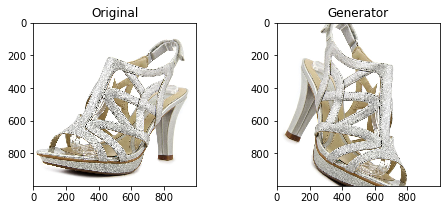

In [9]:
plot_imgs([lst_imgs[0], ImageGen.random_transform(lst_imgs[0])], ["Original","Generator"], figsize=(8,3))  

In [10]:
## Train
print("--- Train ---")
X_train = ImageGen.flow_from_directory(directory="fs/training_cnn/train", target_size=(256,256), color_mode='rgb', 
                                       classes=None, class_mode='categorical', shuffle=True, batch_size=32)

## Test
print("--- Test ---")
X_test = ImageGen.flow_from_directory(directory="fs/training_cnn/validation", target_size=(256,256), color_mode='rgb', 
                                      classes=None, class_mode='categorical', shuffle=True, batch_size=32)

--- Train ---
Found 521 images belonging to 3 classes.
--- Test ---
Found 22 images belonging to 3 classes.


In [12]:
print(X_train.class_indices)

dic_y_mapping = {v:k for k,v in X_train.class_indices.items()}
print(dic_y_mapping)

{'0_50': 0, '50_100': 1, 'over100': 2}
{0: '0_50', 1: '50_100', 2: 'over100'}


### 3 - Model Desing & Testing (CNN for classification: training from scratch)

###### Train

In [13]:
## CNN
### layer 1 conv 5x5 (32 neurons) + pool 2x2
model = models.Sequential()
model.add( layers.Conv2D(input_shape=(256,256,3), kernel_size=(5,5), filters=32, strides=(1,1), padding="valid", activation='relu') )
model.add( layers.MaxPooling2D(pool_size=(2,2), padding="valid") )
### layer 2 conv 3x3 (64 neurons) + pool 2x2
model.add( layers.Conv2D(kernel_size=(3,3), filters=64, strides=(1,1), padding="valid", activation='relu') )
model.add( layers.MaxPooling2D(pool_size=(2,2), padding="valid") )
### layer 3 fully connected (128 neuroni)
model.add( layers.Flatten() )
model.add( layers.Dense(units=128, activation="relu") )
model.add( layers.Dropout(rate=0.2) )
## layer output
model.add( layers.Dense(units=3, activation="softmax") )
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


y multiclasses --> output layer:  3 neurons with 'softmax' activation and 'categorical_crossentropy' loss
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 252, 252, 32)      2432      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 246016)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               31490176  
____________________________________

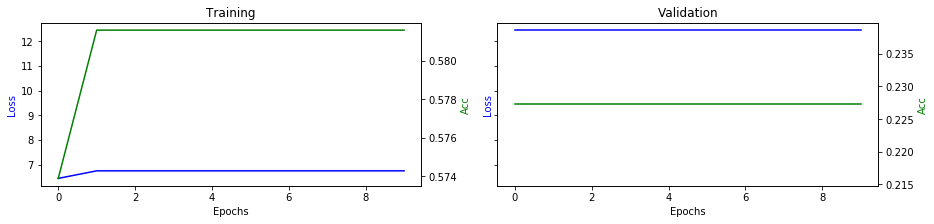

In [16]:
# this takes a while
cnn = fit_cnn(X_train, X_test, model=None, batch_size=32, epochs=10, savepath="fs/pretrained_models/")

###### Evaluate

### 4 - Model Desing & Testing (CNN for classification: transfer learning)

###### Train

In [17]:
# Base model
base = applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(256,256,3))
for layer in base.layers:
    layer.trainable = False

In [18]:
# Adding layers
new_layer = base.output
new_layer = layers.Flatten()(new_layer)
new_layer = layers.Dense(units=1024, activation='relu')(new_layer)
new_layer = layers.Dropout(rate=0.5)(new_layer)
new_layer = layers.Dense(units=3, activation="softmax")(new_layer)

--- check ---
Base model requires input of shape: (256, 256, 3)
X shape: (256, 256, 3)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 128, 128, 64) 256         conv1[0][0]                      
______________________

1/1 [==============================] - 6s 6s/step - loss: 12.4549 - acc: 0.2273


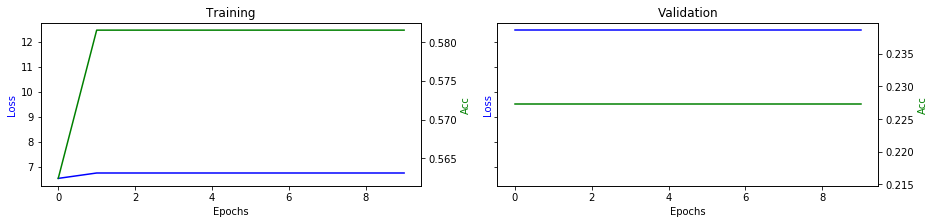

In [19]:
# this takes a while
cnn_trf = fit_cnn_transfer_learning(X_train, X_test, base=base, new_layer=new_layer, batch_size=32, epochs=10, 
                                    savepath="fs/pretrained_models/")

###### Evaluate

### 5 - Preprocessing for Detection

###### Features Engineering

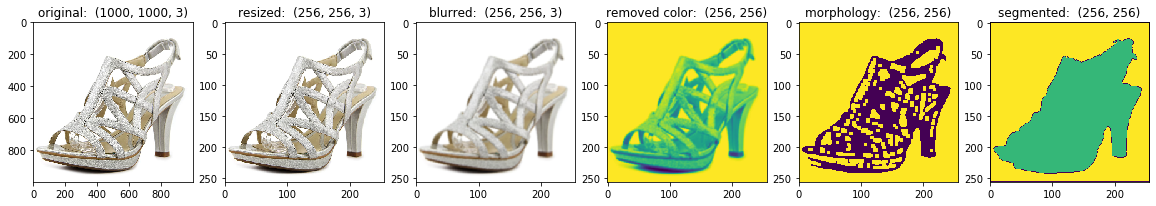

In [119]:
ex = utils_preprocess_img(lst_imgs[0], resize=256, denoise=True, remove_color=True, morphology=True, segmentation=True, plot=True)

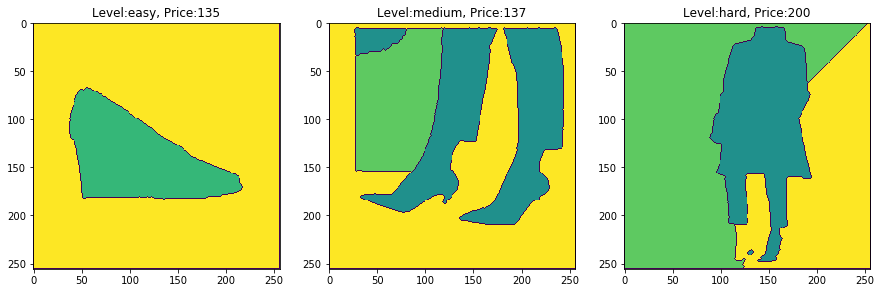

In [122]:
lst_new_imgs_processed = [utils_preprocess_img(new_img, plot=False, resize=256, denoise=True, 
                                               remove_color=True, morphology=True, segmentation=True) 
                          for new_img in lst_new_imgs]
plot_imgs(lst_new_imgs_processed, lst_titles=["Level:easy, Price:135", "Level:medium, Price:137", "Level:hard, Price:200"], figsize=(15,10))

In [ ]:
#lst_imgs = [utils_preprocess_img(img, resize=256, denoise=True, remove_color=True, morphology=True) for img in lst_imgs]

In [ ]:
# No preprocessing needed

###### Partitioning

In [21]:
split = int(len(lst_imgs)*0.90)

# Train
print("Train: ", split, "images")
save_imgs(lst_imgs=lst_imgs[:split], dirpath="fs/training_yolo/train/images/", i=0)

# Test
print("Test: ", len(lst_imgs)-split, "images")
save_imgs(lst_imgs=lst_imgs[split:], dirpath="fs/training_yolo/validation/images/", i=split)

Train:  488 images
Test:  55 images


###### Create Annotations

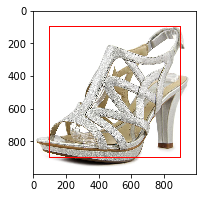

In [22]:
# Check what rectangle measures shall be appropriate
img = lst_imgs[0]
xmin = int(img.shape[0]*0.10)
ymin = int(img.shape[1]*0.10)
xmax = int(img.shape[0]*0.90)
ymax = int(img.shape[1]*0.90)
utils_plot_img(img, mask=None, rect=[(xmin,ymin), (xmax,ymax)], figsize=(5,3))

In [23]:
# Creating xml annotation file for each image
import xml.etree.cElementTree as XML

def create_annotations(lst_imgs, dirpath_annot, dirpath_img, i=0):
    for img in lst_imgs:
        try:
            img_name, xml_name = str(i)+".jpg", str(i)+".xml"

            ## xml structure
            annotation = XML.Element("annotation")
            XML.SubElement(annotation, "folder").text = "images"
            XML.SubElement(annotation, "filename").text = img_name
            XML.SubElement(annotation, "path").text = dirpath_img+img_name

            source = XML.SubElement(annotation, "source")
            XML.SubElement(source, "database").text = "Unknown"

            size = XML.SubElement(annotation, "size")
            XML.SubElement(size, "width").text = str(img.shape[0])
            XML.SubElement(size, "height").text = str(img.shape[1])
            XML.SubElement(size, "depth").text = str(img.shape[2])

            XML.SubElement(annotation, "segmented").text = "0"

            object = XML.SubElement(annotation, "object")
            XML.SubElement(object, "name").text = "shoes"
            XML.SubElement(object, "pose").text = "Unspecified"
            XML.SubElement(object, "truncated").text = "0"
            XML.SubElement(object, "difficult").text = "0"
            bndbox = XML.SubElement(object, "bndbox")
            XML.SubElement(bndbox, "xmin").text = str(int(img.shape[0]*0.10))
            XML.SubElement(bndbox, "ymin").text = str(int(img.shape[1]*0.10))
            XML.SubElement(bndbox, "xmax").text = str(int(img.shape[0]*0.90))
            XML.SubElement(bndbox, "ymax").text = str(int(img.shape[1]*0.90))

            ## write xml
            xml_file = XML.ElementTree(annotation)
            xml_file.write(dirpath_annot+xml_name)
            i += 1

        except Exception as e:
            print("failed on:", i, "| error:", e)
            i += 1
            pass

In [24]:
# Train
create_annotations(lst_imgs[:split], dirpath_annot="fs/training_yolo/train/annotations/", 
                                     dirpath_img="fs/training_yolo/train/images/", i=0)
# Test
create_annotations(lst_imgs[split:], dirpath_annot="fs/training_yolo/validation/annotations/", 
                                     dirpath_img="fs/training_yolo/validation/images/", i=split)

failed on: 90 | error: tuple index out of range


In [25]:
file = XML.parse("fs/training_yolo/train/annotations/0.xml")
root = file.getroot()
print(root.tag)
for elem in root:
    print(" ", elem.tag, ":", elem.text)
    if len(elem.getchildren()) > 0:
        for subelem in elem:
            print("   - ", subelem.tag, ":", subelem.text)
            if len(subelem.getchildren()) > 0:
                for subsubelem in subelem:
                    print("     - ", subsubelem.tag, ":", subsubelem.text)

annotation
  folder : images
  filename : 0.jpg
  path : fs/training_yolo/train/images/0.jpg
  source : None
   -  database : Unknown
  size : None
   -  width : 1000
   -  height : 1000
   -  depth : 3
  segmented : 0
  object : None
   -  name : shoes
   -  pose : Unspecified
   -  truncated : 0
   -  difficult : 0
   -  bndbox : None
     -  xmin : 100
     -  ymin : 100
     -  xmax : 900
     -  ymax : 900


### 6 - Model Desing & Testing (YOLO for detection)

###### Train

In [29]:
# this takes 10 hours
yolo = train_yolo(lst_y=["shoes"], train_path="fs/training_yolo/", transfer_modelfile="fs/pretrained_models/yolo_base.h5")

Generating anchor boxes for training images and annotation...
Average IOU for 9 anchors: 1.00
Anchor Boxes generated.
Detection configuration saved in  fs/training_yolo/json\detection_config.json
--- training ---
Training on: 	['shoes']
Training with Batch Size:  4
Number of Experiments:  1
Instructions for updating:
Use tf.cast instead.
Training with transfer learning from pretrained Model
Epoch 1/1
976/976 [==============================] - 27861s 29s/step - loss: 25.9413 - yolo_layer_1_loss: 7.7407 - yolo_layer_2_loss: 4.1500 - yolo_layer_3_loss: 14.0506 - val_loss: 2.1288 - val_yolo_layer_1_loss: 5.6893 - val_yolo_layer_2_loss: 0.0201 - val_yolo_layer_3_loss: 0.2659
--- metrics ---
Starting Model evaluation....
Model File:  fs/training_yolo/models\detection_model-ex-001--loss-0025.941.h5 

Using IoU :  0.5
Using Object Threshold :  0.5
Using Non-Maximum Suppression :  0.5
shoes: 0.6436
mAP: 0.6436
[{'model_file': 'fs/training_yolo/models\\detection_model-ex-001--loss-0025.941.h5', 

In [35]:
#yolo = load_yolo(modelfile="fs/pretrained_models/yolo_shoes_nopreprocess.h5", 
#                 confjson="fs/pretrained_models/detection_config.json")

###### Evaluate

### 7 - Putting all together: classification of detected objects

###### Detect

In [36]:
yolo_predicted = [obj_detect_yolo(new_img, yolo, min_prob=60) for new_img in lst_new_imgs]

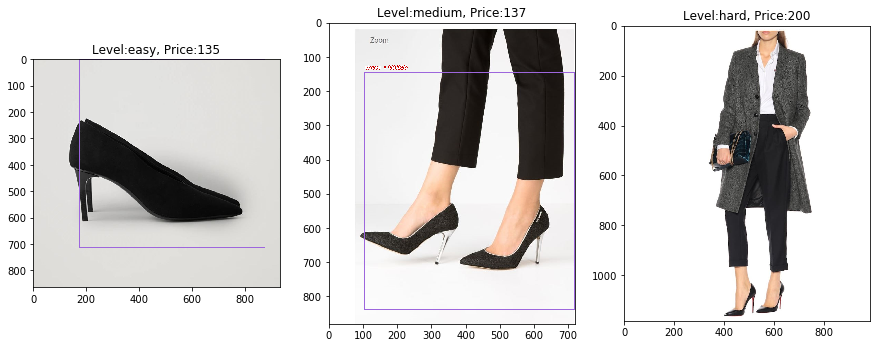

In [37]:
full_imgs = [i[0] for i in yolo_predicted]
plot_imgs(full_imgs, lst_titles=["Level:easy, Price:135", "Level:medium, Price:137", "Level:hard, Price:200"], figsize=(15,10))

###### Classify

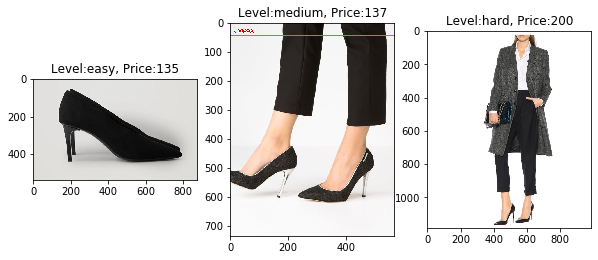

In [41]:
cropped_imgs = [i[2] for i in yolo_predicted]
plot_imgs(cropped_imgs, lst_titles=["Level:easy, Price:135", "Level:medium, Price:137", "Level:hard, Price:200"], figsize=(10,5))

In [39]:
dic_y_mapping

{0: '0_50', 1: '50_100', 2: 'over100'}

In [40]:
for x in cropped_imgs:
    shape = cnn.input_shape[1]
    x = cv2.resize(x, (shape,shape), interpolation=cv2.INTER_LINEAR)
    x = np.expand_dims(x, axis=0)
    predicted_prob = cnn.predict(x)
    predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob]
    print("predicted:", predicted[0])

predicted: 0_50
predicted: 0_50
predicted: 0_50
